# 지도학습-XGboost(2)

In [29]:
from hossam import *

# 파이썬 기본 라이브러리
from pandas import DataFrame, concat, get_dummies, Series
import numpy as np
from itertools import combinations

# 시각화 라이브러리
from matplotlib import pyplot as plt
import seaborn as sb

# 통계 라이브러리
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import linear_reset, het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson
from pingouin import anova, welch_anova
from scipy.stats import (
    normaltest,
    bartlett,
    levene,
    ttest_ind,
    pearsonr,
    spearmanr,
    shapiro,
    jarque_bera,
    t,
    f,
)

# 머신러닝 라이브러리
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve

# 학습모델
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    SGDRegressor
)

# 성능 평가 지표 모듈
from sklearn.metrics import(
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)

# 확률적 경사 하강법
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance

# 랜덤포레스트
from sklearn.ensemble import RandomForestRegressor
import shap

# DecisionTree
from sklearn.tree import DecisionTreeRegressor
# BoostRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

# XGboost
from xgboost import XGBRegressor

def hs_get_scores(estimator, x_test, y_true):
    if hasattr(estimator, 'named_steps'):
        classname = estimator.named_steps['model'].__class__.__name__
    else:
        classname = estimator.__class__.__name__

    y_pred = estimator.predict(x_test)

    result_df = DataFrame(
        {
            '결정계수(R2)': r2_score(y_true, y_pred),
            '평균절대오차(MAE)': mean_absolute_error(y_true, y_pred),
            '평균제곱오차(MSE)': mean_squared_error(y_true, y_pred),
            '평균오차(RMSE)': np.sqrt(mean_squared_error(y_true, y_pred)),
            '평균 절대 백분오차 비율(MAPE)': mean_absolute_percentage_error(y_true,y_pred),
            '평균 비율 오차(MPE)': np.mean((y_true - y_pred) / y_true * 100)
        },
        index = [classname]
)

def hs_learning_cv(
        estimator,
        x,
        y,
        scoring ='neg_root_mean_squared_error',
        cv=5,
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs = 1
):
    train_sizes, train_scores, cv_scores = learning_curve(
        estimator=estimator,
        X=x,
        y=y,
        train_sizes=train_sizes,
        cv=cv,
        scoring=scoring,
        n_jobs=n_jobs,
        shuffle=True,
        random_state=52
    )

    model_name = estimator.named_steps['model'].__class__.__name__
    print(f'=== Learning Curve: {model_name}===')

    # neg RMSE -> RMSE
    train_rmse = -train_scores
    cv_rmse = -cv_scores

    # 평균 / 표준편차
    train_mean = train_rmse.mean(axis=1)
    cv_mean = cv_rmse.mean(axis=1)
    cv_std = cv_rmse.std(axis=1)

    # 마지막 지정 기준 정량 판정
    final_train = train_mean[-1]
    final_cv = cv_mean[-1]
    final_std = cv_std[-1]
    gap_ratio = final_train / final_cv
    var_ratio = final_std / final_cv
    
    # 과소적합 기준선 (some_threshold)
    # 기준모형 RMSE (평균예측)

    y_mean = y.mean()
    rmse_naive = np.sqrt(np.mean((y - y_mean) ** 2))

    # 분산 기반
    std_y = y.std()

    # 최소 설명력(R2)기반
    min_r2 = 0.10
    rmse_r2 = np.sqrt((1 - min_r2) * np.var(y))

    # 최종 threshold (가장 관대한 기준)
    # -> 원래 some_threshold는 도메인 지식 수준에서 이 모델은 최소 어느 정도의 성능은 내야 한다는 기준을 설정하는 것

    some_threshold = min(rmse_naive, std_y, rmse_r2)

    if gap_ratio >= 0.95 and final_cv > some_threshold:
        status = ('과소적합: bias 큼')
    elif gap_ratio <= 0.8:
        status = ('과대적합: variance 큼')
    elif gap_ratio <= 0.95 and var_ratio <= 0.10:
        status = ('일반화 양호')
    elif var_ratio > 0.15:
        status = ('데이터 부족: 분산 큼')
    else:
        status = ('판단 유보: 추가 지표 필요')

    # 정량 결과 표
    result_df = DataFrame({
        '지표': [
            'Train RMSE',
            'CV RMSE 평균',
            'CV RMSE 표준편차',
            'Train/CV 비율',
            'CV 변동성 비율',
            '판정 결과'
        ],
        '값':[
            final_train,
            final_cv,
            final_std,
            gap_ratio,
            var_ratio,
            status,
        ]
    })

    display(result_df)

    # 시각화

    figsize = (1200/my_dpi, 720/my_dpi)
    fig, ax = plt.subplots(1, 1, figsize = figsize, dpi = my_dpi)

    sb.lineplot(x = train_sizes, y = train_mean, marker = 'o', markeredgecolor = '#ffffff', label ='Train RMSE')
    sb.lineplot(x = train_sizes, y = cv_mean, marker = 'o', markeredgecolor = '#ffffff', label ='Train RMSE')


    ax.set_xlabel('RMSE', fontsize=8, labelpad=5)
    ax.set_ylabel('학습곡선(Learning Curve)', fontsize=8, labelpad=5)
    ax.grid(True, alpha = 0.3)

    plt.tight_layout()
    plt.show()
    plt.close()
def get_score_cv(
    estimator,
    x_test: DataFrame,
    y_test: DataFrame | np.ndarray,
    x_origin: DataFrame,
    y_origin: DataFrame | np.ndarray,
    scoring="neg_root_mean_squared_error",
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=1,
) -> DataFrame:
    """
    회귀 성능 평가 지표 함수.
    수업에서 사용된 hs_get_score_cv 함수와 동일.

    Args:
        estimator: 학습된 사이킷런 회귀 모델
        x_test: 테스트용 설명변수 데이터 (DataFrame)
        y_test: 실제 목표변수 값 (DataFrame 또는 ndarray)
        x_origin: 학습곡선용 전체 설명변수 데이터 (DataFrame, learning_curve=True일 때 필요)
        y_origin: 학습곡선용 전체 목표변수 값 (DataFrame 또는 ndarray, learning_curve=True일 때 필요)
        scoring: 학습곡선 평가 지표 (기본값: neg_root_mean_squared_error)
        cv: 학습곡선 교차검증 폴드 수 (기본값: 5)
        train_sizes: 학습곡선 학습 데이터 비율 (기본값: np.linspace(0.1, 1.0, 10))
        n_jobs: 학습곡선 병렬 처리 개수 (기본값: -1, 모든 CPU 사용)

    Returns:
        DataFrame: 회귀 성능 평가 지표 + 과적합 판정 여부
    """

def feature_importance(model, x_train, y_train):
    perm = permutation_importance(
        estimator=model,
        X=x_test,
        y=y_test,
        scoring='r2',
        n_repeats=30,
        random_state=42,
        n_jobs =1
    )

    # 결과 정리
    perm_df = DataFrame(
        {
            'importance_mean': perm.importances_mean,
            'importance_std': perm.importances_std,
        },
        index = x_test.columns
    ).sort_values('importance_mean', ascending=False)

    # 시각화
    df = perm_df.sort_values(by = 'importance_mean', ascending = False)

    figsize = (1280/my_dpi, 600/my_dpi)
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

    sb.barplot(data=df, x='importance_mean', y=df.index)

    ax.set_title('Permutation Importance')
    ax.set_xlabel('Permutation Importance(mean)')

    plt.tight_layout()
    plt.show()
    plt.close()

    return perm_df
def hs_shap_analysis(model, x: DataFrame, plot: bool = True, width: int = 1600, height: int = 800):
    # 1. SHAP Explainer
    explainer = shap.TreeExplainer(model)

    # 2. SHAP 값 계산: shape = [n_samples, n_features]
    shap_values = explainer.shap_values(x)
    
    # 3. DataFrame 변환
    shap_df = DataFrame(
        shap_values,
        columns = x.columns,
        index = x.index
    )

    # 4. 요약 통계
    summary_df = DataFrame(
        {
            'feature': shap_df.columns,
            'mean_abs_shap': shap_df.abs().mean().values,
            'mean_shap': shap_df.mean().values,
            'std_shap': shap_df.std().values
        }
    )

    # 5. 영향 방향 (보수적 표현)
    summary_df['direction'] = np.where(
        summary_df['mean_shap'] > 0,
        '양(+) 경향',
        np.where(summary_df['mean_shap'] < 0, '음(-) 경향', '혼합/미약')
    )

    # 6. 변동성 지표
    summary_df['cv'] = (
        summary_df['std_shap'] / (summary_df['mean_abs_shap'] + 1e-9)
    )

    summary_df['variability'] = np.where(
        summary_df['cv'] < 1,
        'stable',   # 변동성 낮음 ->  평균 대비 일관적 영향 의미
        'variable', # 변동성 큼 -> 상황 의존적 영향 의미
    )

    # 7. 중요도 기준 정렬
    summary_df =(
        summary_df.sort_values('mean_abs_shap', ascending = True).reset_index(drop = True)
    )

    # 8. 중요 변수 표시(누적 80%)
    total_importance = summary_df['mean_abs_shap'].sum()
    summary_df['importance_ratio'] = (
        summary_df['mean_abs_shap'] / total_importance
    )
    summary_df['importance_cumsum'] = summary_df['importance_ratio'].cumsum()

    summary_df['is_important'] = np.where(
        summary_df['importance_cumsum'] <= 0.80,
        'core',      # 누적 80% 내 중요 변수 - 모델 핵심 결정 요인 의미 명확
        'secondary'  # 누적 80% 초과 변수 -보조적/상황적 영향 요인 의미
    )

    # 9. 시각화
    if plot:
        shap.summary_plot(shap_values, x_train, show = False)

        fig = plt.gcf()
        fig.set_size_inches(width / my_dpi, height / my_dpi)

        plt.title('SHAP Summary Plot', fontsize = 10, pad = 10)
        plt.xlabel('SHAP value', fontsize = 8)
        plt.xticks(fontsize = 6)
        plt.yticks(fontsize = 8)
        plt.grid(True, alpha = 0.3)

        plt.tight_layout()
        plt.show()
        plt.close()

    return summary_df, shap_values
def hs_shap_dependence_analysis(
        summary_df: DataFrame,
        shap_values,
        x_train: DataFrame,
        include_secondary: bool = False,
        width: int = 1600,
        height: int = 800
):
    # 1. 주 대상 변수 (core + variable)
    main_features = summary_df[
        (summary_df['is_important'] == 'core')
        & (summary_df['variability'] == 'variable')
        ]['feature'].tolist()
    
    # 2. 상호작용 후보 변수
    interaction_features = summary_df[
        summary_df['is_important'] == 'core'
    ]['feature'].tolist()

    if include_secondary and len(interaction_features) < 2:
        interaction_features.extend(
            summary_df[
                summary_df['is_important'] == 'secondary'
            ]['feature'].tolist()
        )

    # 3. 변수 쌍 생성 (자기 자신 제외)
    pairs = []

    for f in main_features:
        for inter in interaction_features:
            # 자기 자신과의 조합은 제외
            if f != inter:
                pairs.append((f, inter))

    # 중요도 순 정렬 (주 변수 기준)
    importance_rank = {}

    for i, row in summary_df.iterrows():
        importance_rank[row['feature']] = i

    pairs = sorted(
        pairs,
        key=lambda x: importance_rank.get(x[0], 999)
    )

    # 4. dependence plot 일괄 생성
    for feature_name, interaction_name in pairs:
        shap.dependence_plot(
            feature_name,
            shap_values,
            x_train,
            interaction_index = interaction_name,
            show = False
        )

        # SHAP figure 직접 제어
        fig = plt.gcf()
        fig.set_size_inches(width / my_dpi, height / my_dpi)

        plt.title(
            f'SHAP Dependence Plot: {feature_name} x {interaction_name}',
            fontsize = 10,
            pad = 10
        )

        plt.xlabel(feature_name, fontsize = 10)
        plt.ylabel(f'SHAP value for {feature_name}', fontsize = 10)
        plt.xticks(fontsize = 6)
        plt.yticks(fontsize = 8)
        plt.grid(True, alpha = 0.3)

        plt.tight_layout()
        plt.show()
        plt.close()
    return pairs
origin = load_data('restaurant_sales_preprocessed')
origin.set_index('date', inplace = True)
origin['holiday'] = origin['holiday'].astype('int')
origin['weekend'] = origin['weekend'].astype('int')
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print(origin.info())
origin.head()

어느 식당의 1년간 일별 매출을 기록한 데이터의 전처리 완료 버전(명목형이 이진변수만 있으므로 더미변수는 처리하지 않음)
데이터셋 크기: (353, 9)
열 개수: 9
행 개수: 353
<class 'pandas.DataFrame'>
DatetimeIndex: 353 entries, 2024-01-01 to 2024-12-30
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sales           353 non-null    float64
 1   visitors        353 non-null    int64  
 2   avg_price       353 non-null    int64  
 3   marketing_cost  353 non-null    float64
 4   delivery_ratio  353 non-null    float64
 5   rain_mm         353 non-null    float64
 6   temperature     353 non-null    float64
 7   holiday         353 non-null    int32  
 8   weekend         353 non-null    int32  
dtypes: float64(5), int32(2), int64(2)
memory usage: 24.8 KB
None


,sales,visitors,avg_price,marketing_cost,delivery_ratio,rain_mm,temperature,holiday,weekend
date,,,,,,,,,
2024-01-01,16.169,122,14490,9.200,0.480,1.946,5.200,0,0
2024-01-02,16.005,106,11880,9.149,0.480,2.079,11.100,0,0
2024-01-03,16.354,120,18010,8.666,0.430,2.595,12.900,1,0
2024-01-04,16.082,115,11160,8.748,0.410,2.028,12.900,0,0
2024-01-05,16.113,124,15480,8.594,0.510,2.197,11.000,0,0


## 1. 준비작업
### 2. 훈련, 학습 데이터 분리

In [30]:
df = origin

yname = 'sales'
x = df.drop(columns = [yname])
y = df[yname]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.25, random_state = 52
)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((264, 8), (89, 8), (264,), (89,))

### 3. 주요 하이퍼파라미터

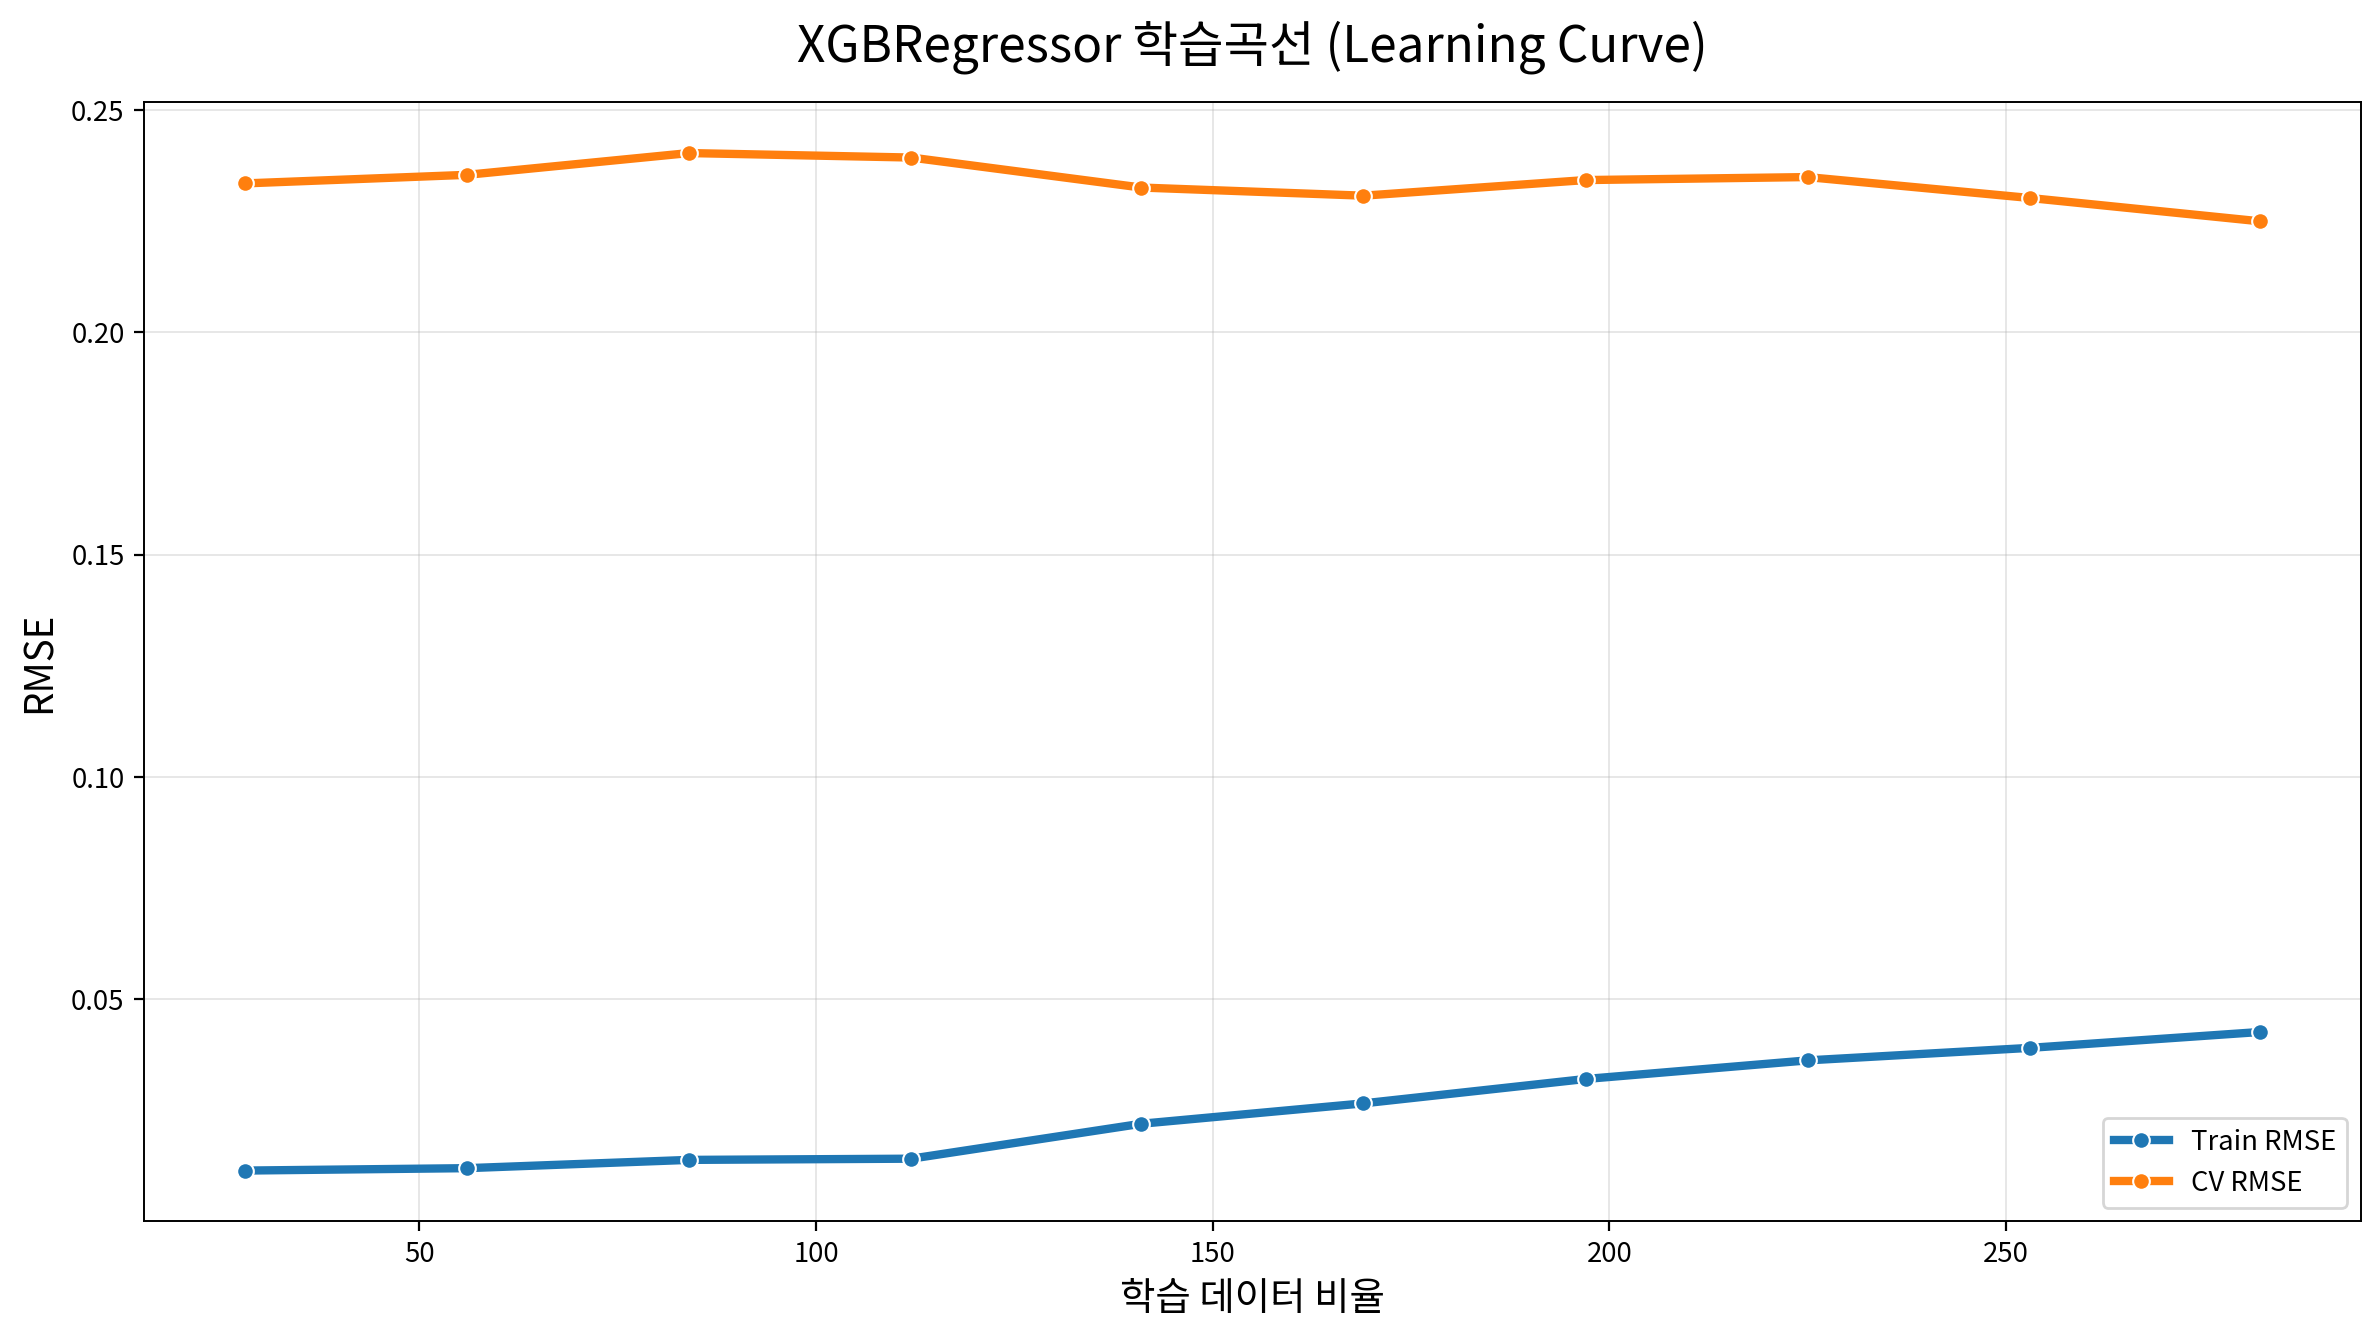

CPU times: total: 26.3 s
Wall time: 3min 3s


,결정계수(R2),평균절대오차(MAE),평균제곱오차(MSE),평균오차(RMSE),평균 절대 백분오차 비율(MAPE),평균 비율 오차(MPE),Train RMSE,CV RMSE 평균,CV RMSE 표준편차,Train/CV 비율,CV 변동성 비율,판정 결과
XGBRegressor,0.990,0.028,0.001,0.038,0.002,0.001,0.043,0.225,0.020,0.190,0.091,⚠️ 데이터 추가시 일반화 기대


In [13]:
%%time

xgb = XGBRegressor(
    objective = 'reg:squarederror',
    random_state = 52,
    n_jobs = 1,
    tree_method ='hist')
# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 5, 10]
    
    # poly 커널 확장용 (필요시 사용, 학습속도가 매우 느려짐)
    # 'model__kernel':['poly'],
    # 'model__degree':[2, 3, 4],
    # 'model__coef0':[0.0, 0.5, 1.0]
    }

# 그리드 서치 객체 생성
gs = GridSearchCV(estimator = xgb, param_grid = param_grid, cv=5, scoring ='r2', n_jobs = -1)

gs.fit(x_train, y_train)
best_model = gs.best_estimator_

hs_get_score_cv(best_model, x_train, y_train, x, y)

## 2. 변수 중요도
### 1. 변수 중요도 표 - Feature importance 추출

In [33]:
booster = best_model.get_booster()

# 성능기여도(중요)
imp = booster.get_score(importance_type = 'gain')
imp

{'visitors': 0.02339032106101513,
 'avg_price': 0.040005043148994446,
 'marketing_cost': 0.06044062227010727,
 'delivery_ratio': 0.02323010191321373,
 'rain_mm': 0.048953671008348465,
 'temperature': 0.029000934213399887,
 'holiday': 0.6552891135215759,
 'weekend': 1.995676875114441}

In [ ]:
best_model.get_booster().feature_names = x_train.columns.tolist()
imp = best_model.get_booster().get_score(importance_type="gain")
imp 


{'visitors': 0.02339032106101513,
 'avg_price': 0.040005043148994446,
 'marketing_cost': 0.06044062227010727,
 'delivery_ratio': 0.02323010191321373,
 'rain_mm': 0.048953671008348465,
 'temperature': 0.029000934213399887,
 'holiday': 0.6552891135215759,
 'weekend': 1.995676875114441}

### 1. 변수 중요도 표 - Seriese 객체로 변환

In [15]:
imp_sr = Series(imp)
imp_sr

f0   0.023
f1   0.040
f2   0.060
f3   0.023
f4   0.049
f5   0.029
f6   0.655
f7   1.996
dtype: float64

### 1. 변수 중요도 표 - 모든 feature이름을 인덱스로 갖는 빈 데이터프레임

In [16]:
imp_df = DataFrame(imp_sr, columns = ['importance'])
imp_df = imp_df.sort_values('importance', ascending = False)
imp_df

,importance
f7,1.996
f6,0.655
f2,0.060
f4,0.049
f1,0.040
f5,0.029
f0,0.023
f3,0.023


### 1. 변수 중요도 표 - 중요도 비율, 누적합 추가

In [18]:
imp_df['ratio'] = imp_df['importance'] / imp_df['importance'].sum()
imp_df['cumsum'] = imp_df['ratio'].cumsum()
imp_df

,importance,ratio,cumsum
f7,1.996,0.694,0.694
f6,0.655,0.228,0.922
f2,0.060,0.021,0.943
f4,0.049,0.017,0.960
f1,0.040,0.014,0.974
f5,0.029,0.010,0.984
f0,0.023,0.008,0.992
f3,0.023,0.008,1.000


### 2. 변수 중요도 시각화

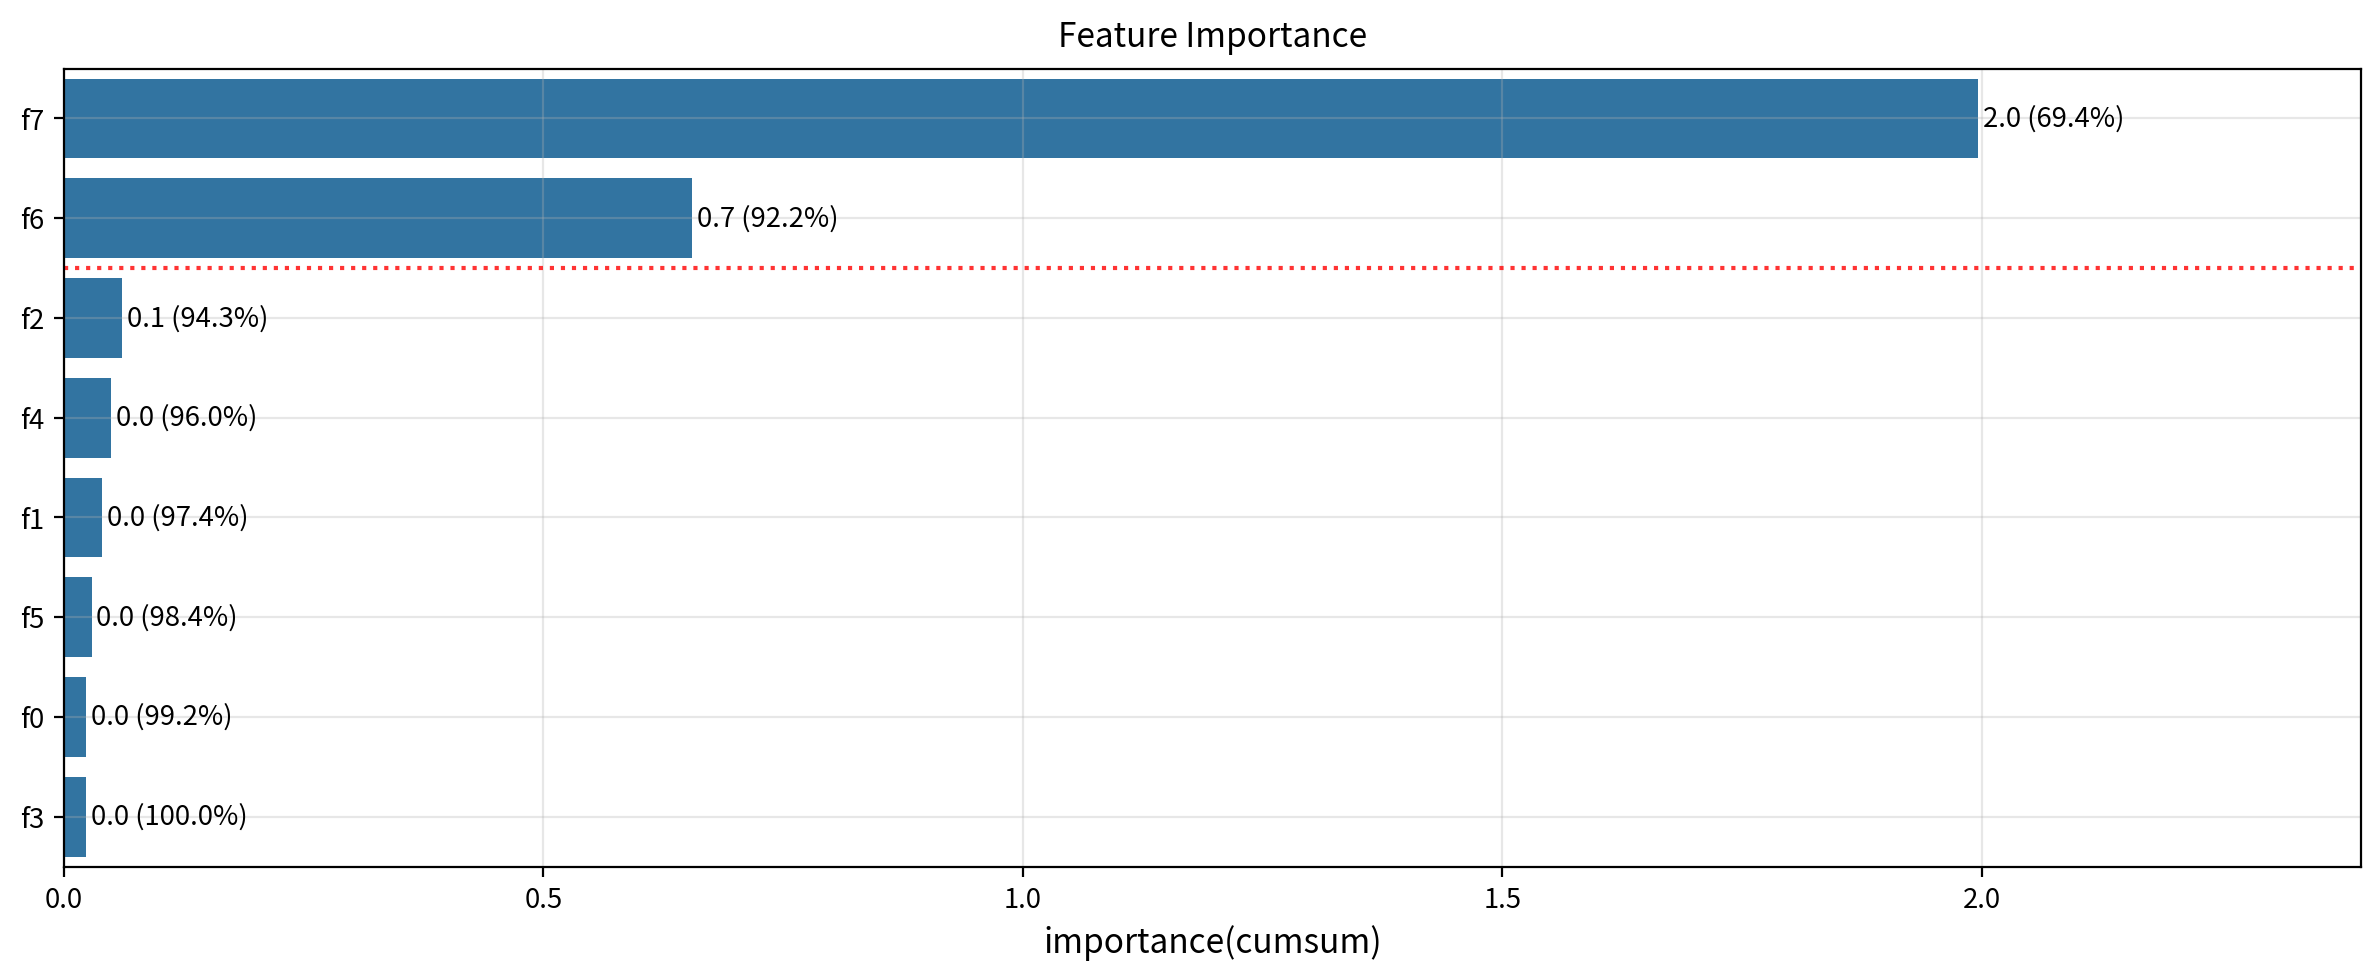

In [24]:
df = imp_df.sort_values(by = 'ratio', ascending = False)
threshold = 0.9

figsize = (1200 / 100, 500 / 100)
fig, ax = plt.subplots(1, 1, figsize = figsize, dpi = my_dpi)

sb.barplot(data = df, x = 'importance', y = df.index)

# 값 라벨 추가
for i,v in enumerate(imp_df['importance']):
    ax.text(
        v + 0.005,                                                # 막대 끝에서 약간 오른쪽
        i,                                                        # y 위치
        f"{v:.1f} ({imp_df.iloc[i]['cumsum']*100:.1f}%)",         # 표시 형식
        va = 'center')

ax.set_title('Feature Importance', fontsize = 12, pad = 8)
ax.set_xlabel('importance(cumsum)', fontsize = 12)
ax.set_ylabel(None)
ax.grid(True, alpha = 0.3)
ax.set_xlim(0, imp_df['importance'].max() * 1.2)

# 90% cjdma ehekfgksms dlseprtm (0-based)
cut_idx = np.argmax(imp_df['cumsum'].values >= threshold)

# x축은 rank 기준이므로 +1
cut_rank = (int(cut_idx) + 1) - 0.5

# 90% 도달 지점 수직선 (핵심)
plt.axhline(
    y = cut_rank,
    linestyle = ':',
    color = 'red',
    alpha = 0.8
)

plt.tight_layout()
plt.show()
plt.close()

## 3. 변수 중요도 확인 함수 개선

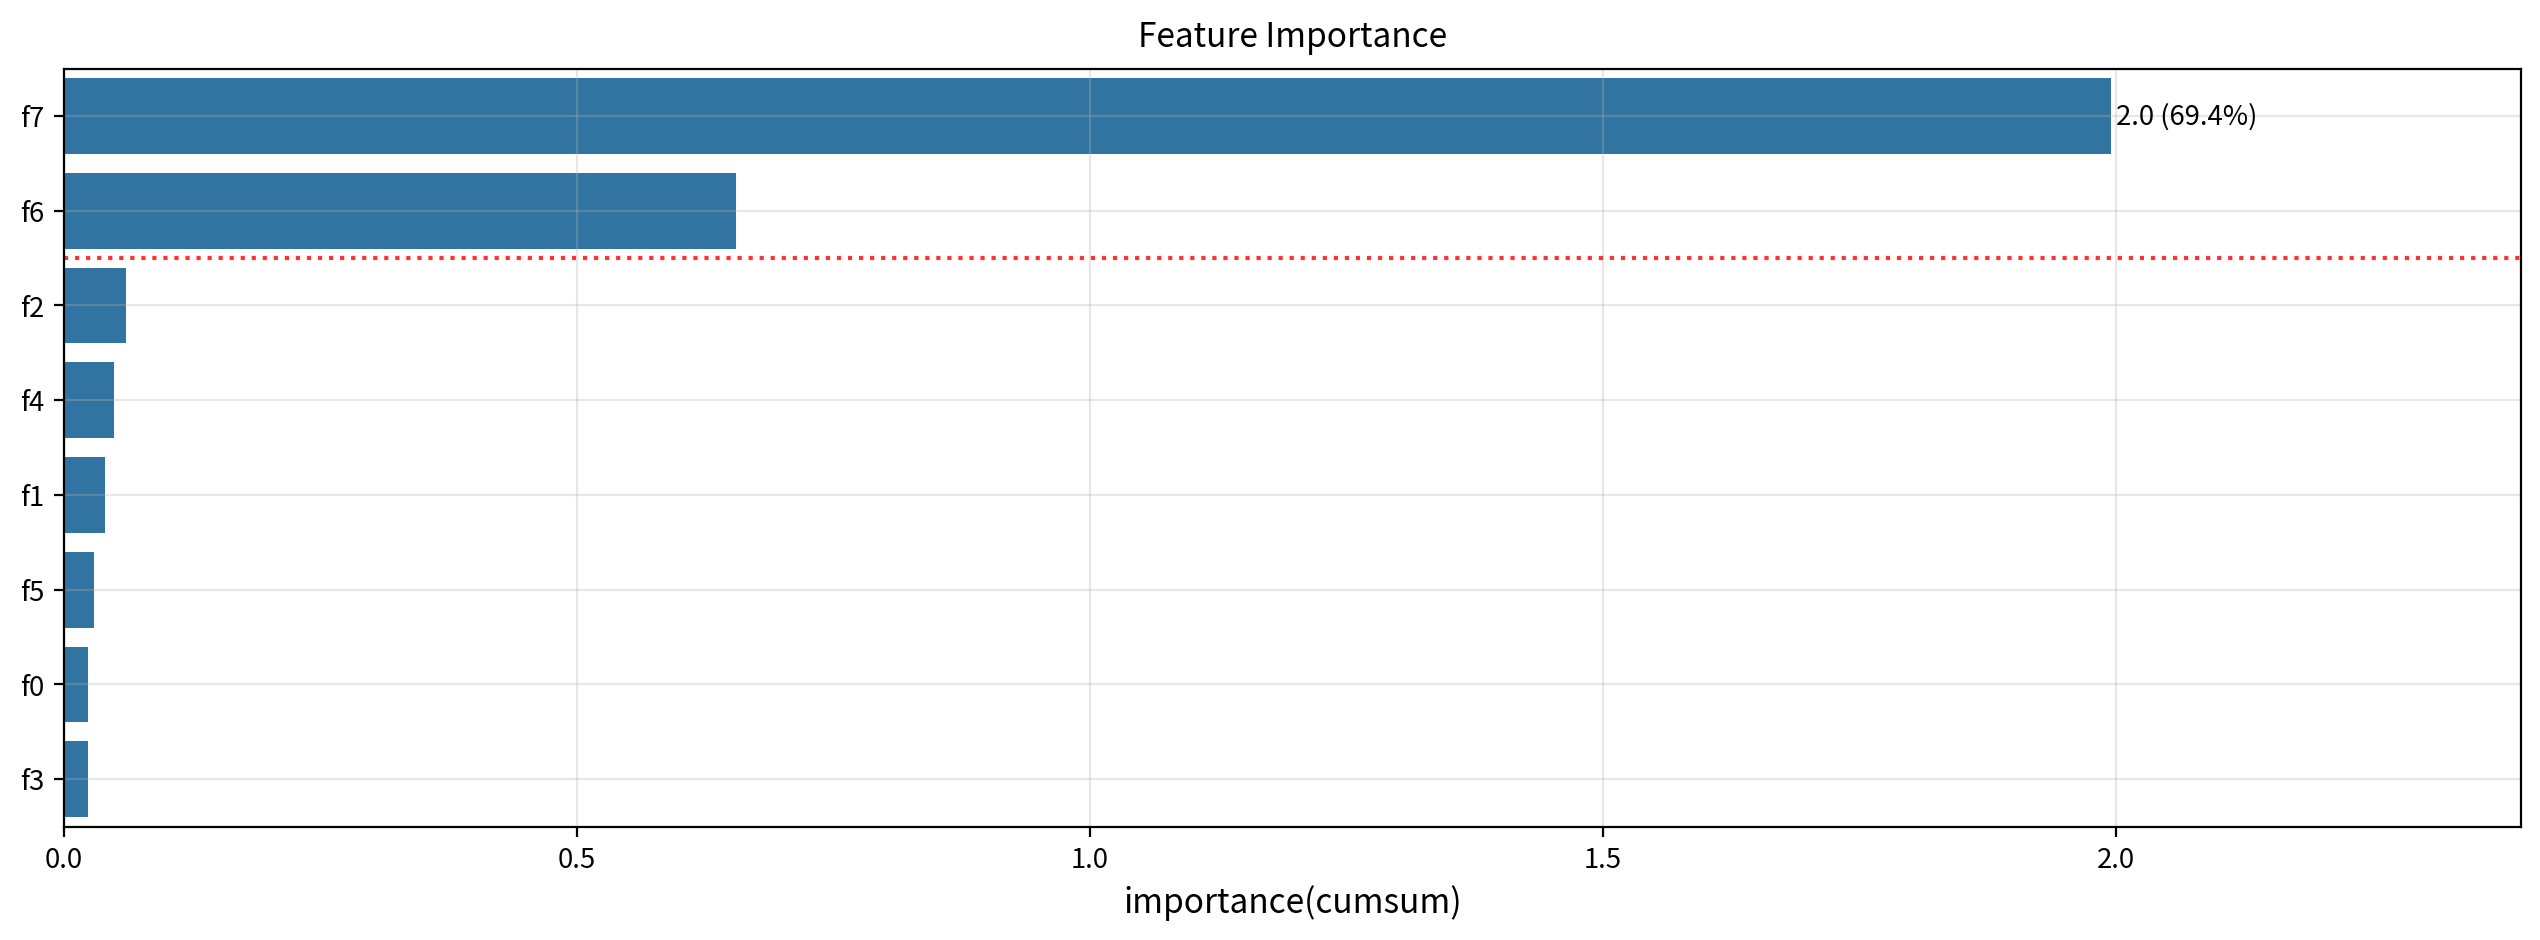

,importance,ratio,cumsum
f7,1.996,0.694,0.694
f6,0.655,0.228,0.922
f2,0.060,0.021,0.943
f4,0.049,0.017,0.960
f1,0.040,0.014,0.974
f5,0.029,0.010,0.984
f0,0.023,0.008,0.992
f3,0.023,0.008,1.000


In [27]:
def hs_feature_importance(model, x_train, y_train):
    if isinstance(model, XGBRegressor):
        booster = model.get_booster()
        imp = booster.get_score(importance_type = 'gain')
        imp_sr = Series(imp)
        imp_df = DataFrame(imp_sr, columns = ['importance'])
    else:
        imp_df = permutation_importance(
            estimator = best_model,
            X = x_train,
            y = y_train,
            scoring = 'r2',
            n_repeats = 30,
            random_state = 42,
            n_jobs = -1
        )

        # 결과 정리
        imp_df = DataFrame({'importance': imp_df.importance_mean},
        index = x_train.columns)

    # 중요도 비율 + 누적 중요도 계산
    imp_df['ratio'] = imp_df['importance'] / imp_df['importance'].sum()
    imp_df.sort_values('ratio', ascending = False, inplace = True)
    imp_df['cumsum'] = imp_df['ratio'].cumsum()

    # 시각화
    df = imp_df.sort_values(by = 'ratio', ascending = False)
    threshold = 0.9
    height = len(imp_df) * 60
    figsize = (1280/100, height/100)
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)
    sb.barplot(data=df, x='importance', y=df.index)

    # 값 라벨 추가
    
    for i,v in enumerate(imp_df['importance']):
        ax.text(
            v + 0.005,                                                # 막대 끝에서 약간 오른쪽
            i,                                                        # y 위치
            f"{v:.1f} ({imp_df.iloc[i]['cumsum']*100:.1f}%)",         # 표시 형식
            va = 'center')

        ax.set_title('Feature Importance', fontsize = 12, pad = 8)
        ax.set_xlabel('importance(cumsum)', fontsize = 12)
        ax.set_ylabel(None)
        ax.grid(True, alpha = 0.3)
        ax.set_xlim(0, imp_df['importance'].max() * 1.2)

        # 90% 처음 도달하는 인덱스 (0-based)
        cut_idx = np.argmax(imp_df['cumsum'].values >= threshold)

        # x축은 rank 기준이므로 +1
        cut_rank = (int(cut_idx) + 1) - 0.5

        # 90% 도달 지점 수직선 (핵심)
        plt.axhline(
            y = cut_rank,
            linestyle = ':',
            color = 'red',
            alpha = 0.8
        )

        plt.tight_layout()
        plt.show()
        plt.close()

        return imp_df
hs_feature_importance(best_model, x_train, y_train)

## 4. SHAP 분석
### - 재현율이 이 파이썬 버전에서는 상당히 떨어짐으로 제외한다